# Анализ результатов АБ-теста
В данном задании вам нужно будет

* проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса;
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами;
* определить характер этих изменений и практическую значимость вводимого изменения;
* понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение).

<b>Описание  данных:</b>

* userID:  уникальный идентификатор пользователя;
* browser:  браузер, который использовал userID;
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу);
* n_clicks: количество кликов, которые пользоваль совершил за n_queries;
* n_queries: количество запросов, который совершил userID, пользуясь браузером browser;
* n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика;
* Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.

Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.stats.weightstats import *

In [2]:
df = pd.read_csv('ab_browser_test.csv')

In [3]:
df.head(10)

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30
5,8,Browser #4,control,4,4,1
6,9,Browser #4,exp,6,3,1
7,10,Browser #4,control,22,15,2
8,13,Browser #14,exp,2,4,3
9,15,Browser #14,control,2,2,0


In [4]:
exp_group = df[df['slot'] == 'exp']
control_group = df[df['slot'] == 'control']

In [5]:
exp_clicks = exp_group['n_clicks'].sum()
control_clicks = control_group['n_clicks'].sum()

In [6]:
100 * (float(exp_clicks) - float(control_clicks)) / control_clicks

1.6135689824415806

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [8]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [9]:
exp_mean_scores = map(np.mean, get_bootstrap_samples(exp_group['n_clicks'].values, 1000))
control_mean_scores = map(np.mean, get_bootstrap_samples(control_group['n_clicks'].values, 1000))
delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores))
print "mean exp:", stat_intervals(exp_mean_scores, 0.05)
print "mean control:", stat_intervals(control_mean_scores, 0.05)
print "mean dif:", stat_intervals(delta_median_scores, 0.05)

mean exp: [11.51082845 11.65365029]
mean control: [11.21888332 11.35878682]
mean dif: [-0.4013381  -0.20075229]


In [10]:
exp_median_scores = map(np.median, get_bootstrap_samples(exp_group['n_clicks'].values, 1000))
control_median_scores = map(np.median, get_bootstrap_samples(control_group['n_clicks'].values, 1000))
delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores))
print "median exp:",  stat_intervals(exp_median_scores, 0.05)
print "median control:",  stat_intervals(control_median_scores, 0.05)
print "median dif:", stat_intervals(delta_median_scores, 0.05)

median exp: [5. 5.]
median control: [4. 4.]
median dif: [-1. -1.]


t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. 

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных. 

Для простоты рассмотрим одновыборочный t-критерий.  Его статистика имеет вид $\frac{\overline{X}-μ}{\sqrt{S^{2}/n}}$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

* $\overline{X}$  —  среднее значение в выборке — было распределено нормально $N\left(μ,\frac{σ^{2}}{n}\right)$;
* $\frac{n}{σ^{2}}S^{2}$  — несмещенная оценка дисперсии c масштабирующим коэффициентом —  была распределена по хи-квадрат  c $n−1$ степенями свободы  $χ^{2}(n−1)$.

<i>Простое доказательство необходимости и достаточности этого требования  можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.</i>

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса. 

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого 

1. Получите из данных n_boot_samples  псевдовыборок;
2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared);
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения;
4. Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте  qq-plot с помощью scipy.stats.probplot  для хи-квадрат распределения с помощью команды:

scipy.stats.probplot(control_boot_chi_squared, dist="chi2", sparams=(n-1), plot=plt)

Где sparams=(n-1), plot=plt)scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 

Где sparams=(n-1) означают число степеней свободы = длине выборки - 1. 

Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:

np.random.seed(0)
n_boot_samples = 500

В качестве ответа отметьте верные утвердения о  значениях $R^{2}$, которые генерирует scipy.stats.probplot при отображении qq-графиков: одно c графика для среднего  и одно с графика для выборочной суммы квадратов отклонения от выборочной суммы.

<b>Почему мы проверяем именно такие условия?</b>

В исходной постановке t-критерий требует нормальности распределения $X_{i}. Именно из-за этого предположения мы имеем, что $\sum_i X_{i}\sim N \left(nμ, nσ^{2}\right)$ в силу линейности матожидания, независимости всех X_{i} между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна. 

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что $\frac{1}{n}\sum_i X_{i}-μ\sim N \left(0, \frac{σ^{2}}{n}\right)$ 

Заметим теперь, что следующие распределения эквивалентны $N \left(0, \frac{σ^{2}}{n}\right)\sim \sqrt{\frac{σ^{2}}{n}}N \left(0, 1\right)$

То есть другими словами мы получили, что исходная статистика $\frac{\overline{X}-μ}{\sqrt{S^{2}/n}}$ распределена как $\frac{N\left(0,1\right)}{\sqrt{\frac{S^{2}n}{nσ^{2}}}}\sim\frac{N\left(0,1\right)}{\sqrt{\frac{S^{2}}{σ^{2}}}}$

Вспомним, что распределение Стьюдента с $n−1$ степенями свободы  определяется как $\frac{N\left(0,1\right)}{\sqrt{χ^{2}/\left(n-1\right)}}$. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса. 

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по  Хи-квадрат соответственно, для этого необязательно, чтобы именно $X_{i}$ были распределены нормально.   Поэтому, если мы убедимся в том, что, действительно,  числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [11]:
np.random.seed(0)
n_boot_samples = 500
boot_samples = get_bootstrap_samples(control_group['n_clicks'].values, n_boot_samples)

In [12]:
boot_samples_mean = np.mean(boot_samples, axis=1)

In [13]:
boot_samples_dif = []
for i in range(len(boot_samples)):
    dif_sum = 0
    for j in range(len(boot_samples[i])):
        dif_sum += (boot_samples[i, j] - boot_samples_mean[i]) ** 2
    boot_samples_dif.append(dif_sum)
boot_samples_dif = np.array(boot_samples_dif)

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


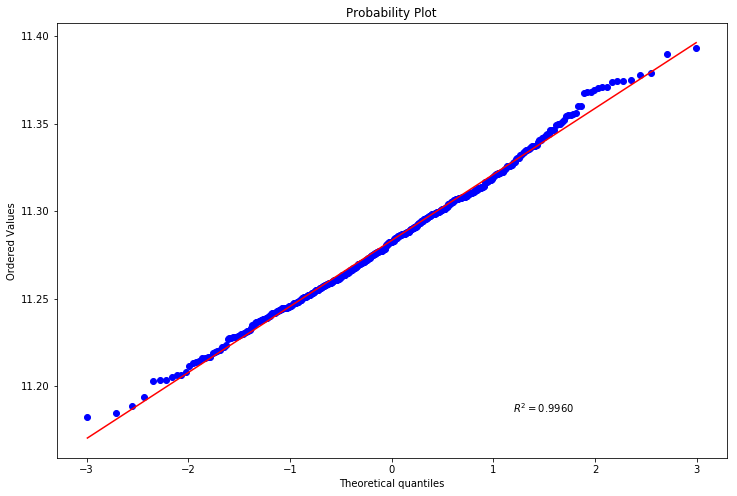

In [15]:
pylab.figure(figsize=(12,8))
stats.probplot(boot_samples_mean, dist="norm", plot=pylab, rvalue=True)
pylab.show()

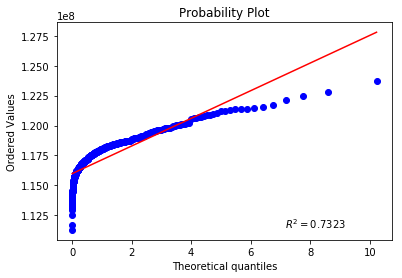

In [16]:
stats.probplot(boot_samples_dif, dist="chi2", sparams=(2-1), plot=pylab, rvalue=True)
pylab.show()

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости?

In [17]:
stats.mannwhitneyu(exp_group['n_clicks'].values, control_group['n_clicks'].values)

MannwhitneyuResult(statistic=38940590204.0, pvalue=3.1236179006848145e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с $α=0.05$.

Какое заключение можно сделать исходя из полученных результатов?

In [18]:
browsers = set(df['browser'].values)

In [19]:
browser_data = []
for browser in browsers:
    stat, p_val = stats.mannwhitneyu(exp_group[exp_group['browser'] == browser]['n_clicks'],
                                     control_group[control_group['browser'] == browser]['n_clicks'])
    browser_data.append([browser, stat, p_val])
browser_data = np.array(browser_data)

In [20]:
browser_data = pd.DataFrame.from_records(browser_data)
browser_data.columns = ['browser', 'stat', 'p_val']

In [21]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [22]:
reject, p_corrected, a1, a2 = multipletests(browser_data['p_val'], alpha = 0.05, method = 'holm')

In [23]:
reject

array([False, False, False, False, False, False])

Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

In [24]:
print len(np.where(reject == False)[0])

6


In [25]:
exp_non_click = []
control_non_click = []
for browser in browsers:
    exp_browser_group = exp_group[exp_group['browser'] == browser]
    exp_non_click.append(float(len(exp_browser_group[exp_browser_group['n_clicks'] == 0])) / len(exp_browser_group))
    control_browser_group = control_group[control_group['browser'] == browser]
    control_non_click.append(float(len(control_browser_group[control_browser_group['n_clicks'] == 0])) / len(control_browser_group))

In [26]:
exp_non_click

[0.1756879732090856,
 0.09814208209642747,
 0.11923185143500281,
 0.0997578406473333,
 0.10871839045099366,
 0.19194934418815016]

In [27]:
control_non_click

[0.18091875324861542,
 0.10124426481615638,
 0.11863557257222415,
 0.10136486645487705,
 0.11208267090620032,
 0.32899806249025676]